# Task 3: Finetune Pre-trained models

In this notebook, we are going to finetune pre-trained models for image classification

- This notebook is the learning notes for task 3 of Image classification (Datawhale Team Learning Session 45). The source code of the jupyter notebook can be find [here](https://github.com/joyenjoye/datawhale_team_learning/tree/main/projects/202301_image_classification). 
- This is built upon the [finetune Pre-trained models](https://github.com/TommyZihao/Train_Custom_Dataset/tree/main/%E5%9B%BE%E5%83%8F%E5%88%86%E7%B1%BB/3-%E3%80%90Pytorch%E3%80%91%E8%BF%81%E7%A7%BB%E5%AD%A6%E4%B9%A0%E8%AE%AD%E7%BB%83%E8%87%AA%E5%B7%B1%E7%9A%84%E5%9B%BE%E5%83%8F%E5%88%86%E7%B1%BB%E6%A8%A1%E5%9E%8B) from [Tommy Zihao](https://github.com/TommyZihao)

In [4]:
%cd ../

/Users/joye/Github/datawhale_team_learning/projects/202301_image_classification


In [2]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install numpy pandas matplotlib seaborn plotly requests tqdm opencv-python pillow wandb -i https://pypi.tuna.tsinghua.edu.cn/simple

In [13]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

# Save model weights checkpoints
if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')

# Save charts and figures
os.mkdir('figures')

In [42]:
!curl https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30_split.zip\
      -o data/fruit30_split.zip\
      --create-dirs

!unzip data/fruit30_split.zip -d data/ >> /dev/null
!rm data/fruit30_split.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  215M  100  215M    0     0  3491k      0  0:01:03  0:01:03 --:--:-- 4062k 0:01:01 2962k 3319k      0  0:01:06  0:00:32  0:00:34 3979k465k


In [50]:
!tree data/fruit30_split -L 2

data/fruit30_split
├── train
│   ├── 梨
│   ├── 山竹
│   ├── 杨梅
│   ├── 柚子
│   ├── 柠檬
│   ├── 桂圆
│   ├── 椰子
│   ├── 榴莲
│   ├── 石榴
│   ├── 脐橙
│   ├── 芒果
│   ├── 苦瓜
│   ├── 草莓
│   ├── 荔枝
│   ├── 菠萝
│   ├── 西瓜
│   ├── 香蕉
│   ├── 黄瓜
│   ├── 苹果-红
│   ├── 苹果-青
│   ├── 葡萄-白
│   ├── 葡萄-红
│   ├── 哈密瓜
│   ├── 圣女果
│   ├── 火龙果
│   ├── 猕猴桃
│   ├── 砂糖橘
│   ├── 胡萝卜
│   ├── 西红柿
│   └── 车厘子
└── val
    ├── 梨
    ├── 山竹
    ├── 杨梅
    ├── 柚子
    ├── 柠檬
    ├── 桂圆
    ├── 椰子
    ├── 榴莲
    ├── 石榴
    ├── 脐橙
    ├── 芒果
    ├── 苦瓜
    ├── 草莓
    ├── 荔枝
    ├── 菠萝
    ├── 西瓜
    ├── 香蕉
    ├── 黄瓜
    ├── 苹果-红
    ├── 苹果-青
    ├── 葡萄-白
    ├── 葡萄-红
    ├── 哈密瓜
    ├── 圣女果
    ├── 火龙果
    ├── 猕猴桃
    ├── 砂糖橘
    ├── 胡萝卜
    ├── 西红柿
    └── 车厘子

63 directories, 0 files


In [51]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

In [52]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


In [53]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [55]:
# 数据集文件夹路径
dataset_dir = 'data/fruit30_split'
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 data/fruit30_split/train
测试集路径 data/fruit30_split/val


In [59]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)
print("***************************")
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)
print()
# 载入测试集
print("***************************")
test_dataset = datasets.ImageFolder(test_path, test_transform)
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)
print()


***************************
训练集图像数量 4375
类别个数 30
各类别名称 ['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']

***************************
测试集图像数量 1078
类别个数 30
各类别名称 ['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']



In [63]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}
print(idx_to_labels)

{0: '哈密瓜', 1: '圣女果', 2: '山竹', 3: '杨梅', 4: '柚子', 5: '柠檬', 6: '桂圆', 7: '梨', 8: '椰子', 9: '榴莲', 10: '火龙果', 11: '猕猴桃', 12: '石榴', 13: '砂糖橘', 14: '胡萝卜', 15: '脐橙', 16: '芒果', 17: '苦瓜', 18: '苹果-红', 19: '苹果-青', 20: '草莓', 21: '荔枝', 22: '菠萝', 23: '葡萄-白', 24: '葡萄-红', 25: '西瓜', 26: '西红柿', 27: '车厘子', 28: '香蕉', 29: '黄瓜'}


In [76]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

print(images.shape)
print(labels)

torch.Size([32, 3, 224, 224])
tensor([ 2,  9,  3,  0, 18, 13, 14, 22, 20, 14, 27, 22,  7, 27, 26, 20, 24,  2,
        22,  6, 28, 15, 11, 14,  5, 19, 24, 10,  3, 13, 16, 25])


In [77]:
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()
print(images[5].shape)

(3, 224, 224)


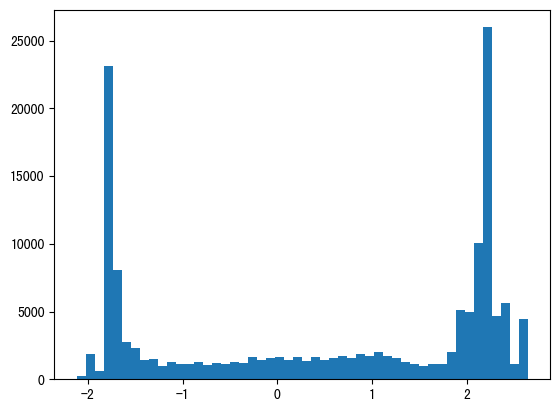

In [78]:
plt.hist(images[5].flatten(), bins=50)
plt.show()

In [79]:
# images[idx].transpose((1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:3')

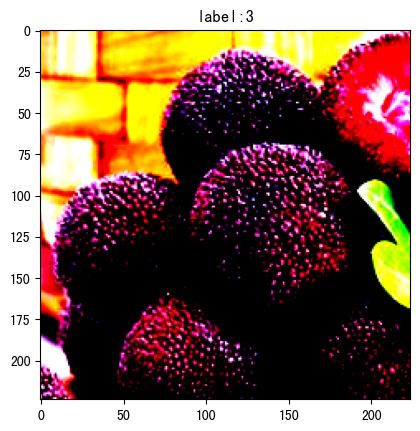

In [80]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [86]:
images[idx].transpose(1,2,0).shape

(224, 224, 3)

In [87]:
images[idx].shape

(3, 224, 224)

In [83]:
p.shape

(224, 224, 3)

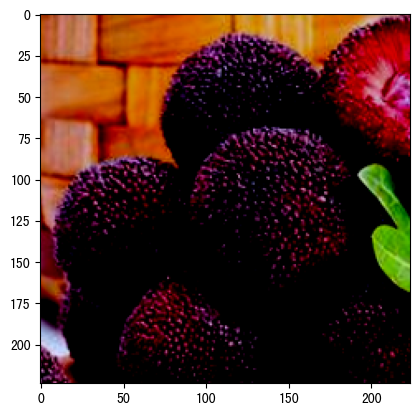

In [88]:
p = images[idx].transpose(1, 2, 0)
p = p/np.amax(p)
p = np.clip(p, 0, 1)
plt.imshow(p)

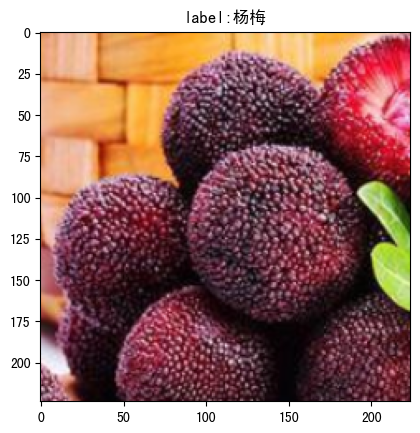

In [91]:
# 原始图像
idx = 2
label = labels[idx].item()
pred_classname = idx_to_labels[label]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()